In [44]:
%load_ext lab_black
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import glob
import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [46]:
def gather_df(dataset_name):
    fname = "./data/kaggle-preprocessed/{}.pkl".format(dataset_name)
    if not os.path.exists(fname):
        raise Exception("preprocessed file doesnt exist")
    df = pd.read_pickle(fname)

    related_datas = []
    for col in df.columns:
        if "rain" in col:
            location = col.replace("rainfall_", "")
        elif "temperature" in col:
            location = col.replace("temperature_", "")
        else:
            continue
        filename = "./data/nasa-power/{}.pkl".format(location)
        if os.path.exists(filename):
            df_related = pd.read_pickle(filename)
            df_related.columns = [
                "{}_{}".format(location, c.lower()) for c in df_related.columns
            ]
            related_datas.append(df_related)
        else:
            print("not found: {}".format(col))
    df_related = pd.concat(related_datas)
    df_related = df_related.groupby(df_related.index).max()
    df = pd.merge(df, df_related, how="left", left_index=True, right_index=True)

    for col in df.columns:
        if "target_" in col:
            df["{}_10_mean".format(col)] = df[col].rolling(10).mean()
            df["{}_10_std".format(col)] = df[col].rolling(10).std()
            df["{}_1y_ago".format(col)] = df[col].shift(365)
            df["{}_1y_ago_10_mean".format(col)] = df[col].rolling(10).mean().shift(365)

    #     for col in ["year", "month", "week", "day_of_year"]:
    #         df = df.drop(col, 1)
    for col in tqdm.tqdm(df.columns):
        decomp = seasonal_decompose(
            df[col].ffill().fillna(0),
            freq=52,
            model="additive",
            extrapolate_trend="freq",
        )
        df[f"{col}_trend"] = decomp.trend
        df[f"{col}_resid"] = decomp.resid
        df[f"{col}_seasonal"] = decomp.seasonal

    return df

In [47]:
df = gather_df("river_arno")
y = df.target_hydrometry_nave_di_rosano

# decompose the target signal into trend/season/resid as well
stl = STL(y.shift(-30).ffill().fillna(0), seasonal=13)
res = stl.fit()
dfy = pd.DataFrame(
    {"season": res.seasonal, "trend": res.trend, "resid": res.resid, "y": y.shift(-30)}
)
dfy["y_comp"] = dfy.season + dfy.trend + dfy.resid


  0%|          | 0/265 [00:00<?, ?it/s]<ipython-input-46-75566f989395>:38: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomp = seasonal_decompose(

100%|██████████| 265/265 [00:00<00:00, 271.29it/s]


In [75]:
# pca might not be a good choice since almost all variables are non-gaussian; the base assumption of PCA
# https://www.sciencedirect.com/science/article/pii/S156625351930377X#sec0025

import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
X_pca = pca.fit_transform(df.fillna(0))

split = 8000

target = dfy.y
X_used = X_pca
filtered = ~pd.isna(target)

model = lgb.LGBMRegressor()
model.fit(X_used[filtered][:split], target[filtered][:split])

dfp = pd.DataFrame({"p": model.predict(X_used[split:]), "y": target[split:]})
print(np.mean((dfp.p - dfp.y) ** 2), dfp.corr())

0.10297796865378513           p         y
p  1.000000  0.556755
y  0.556755  1.000000


In [76]:
for alpha in [0.1, 0.5, 0.9]:
    model = lgb.LGBMRegressor(objective="quantile", alpha=alpha)
    model.fit(X_used[filtered][:split], target[filtered][:split])
    dfp["p_{}".format(alpha)] = model.predict(X_used[split:])

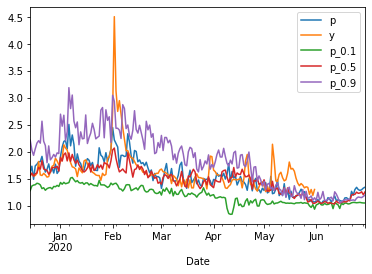

In [77]:
dfp.iloc[-200:].plot()

In [78]:
(dfp.y <= dfp["p_0.9"]).astype(int).mean()

0.6820276497695853

In [79]:
ps = []
for c in ["season", "resid", "trend"]:
    model = lgb.LGBMRegressor()
    model.fit(X_used[filtered][:split], dfy[c].values[filtered][:split])
    ps.append(model.predict(X_used[split:]))
dfp = pd.DataFrame({"p": np.sum(np.array(ps).T, axis=1), "y": target[split:]})
print(np.mean((dfp.p - dfp.y) ** 2), dfp.corr())

0.10316534388753414           p         y
p  1.000000  0.542307
y  0.542307  1.000000


In [103]:
from network import *

p = dict(
    seq_len=28,
    batch_size=60,
    criterion=nn.MSELoss(),
    max_epochs=100,
    n_features=X_used.shape[1],
    hidden_size=128,
    num_layers=1,
    dropout=0.2,
    learning_rate=0.001,
)

model = LSTMRegressor(
    n_features=p["n_features"],
    hidden_size=p["hidden_size"],
    seq_len=p["seq_len"],
    batch_size=p["batch_size"],
    criterion=p["criterion"],
    num_layers=p["num_layers"],
    dropout=p["dropout"],
    learning_rate=p["learning_rate"],
)

/home/opt/anaconda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [104]:
seed_everything(1)

csv_logger = (CSVLogger("./", name="lstm", version="0"),)

trainer = Trainer(max_epochs=p["max_epochs"], logger=csv_logger, gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [105]:
t = target[filtered]

dm = MyDataModule(
    features=X_pca[filtered],
    target=((t - t.mean()) / t.std()).values,
    seq_len=p["seq_len"],
    batch_size=p["batch_size"],
    split=7000,
    pred_ahead=1,
)
trainer.fit(model, dm)

/home/opt/anaconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Experiment logs directory ./lstm/0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | GRU     | 57 K  
2 | hidden    | Linear  | 16 K  
3 | hidden2   | Linear  | 16 K  
4 | linear    | Linear  | 129   
/home/opt/anaconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/opt/anaconda/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/opt/anaconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/opt/anaconda/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


/home/opt/anaconda/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1

In [128]:
ps = []
ys = []
for x in dm.test_dataloader():
    [ps.append(p) for p in model(x[0]).detach().numpy()]
    [ys.append(y) for y in x[1].detach().numpy()]

In [129]:
x[0].shape, x[1].shape

(torch.Size([31, 28, 20]), torch.Size([31]))

In [134]:
dfp = pd.DataFrame({"p": np.array(ps)[:, 0], "y": ys})
dfp = (dfp * target[filtered].std()) + target[filtered].mean()
print(np.mean((dfp.p - dfp.y) ** 2), dfp.corr())

0.2530686989503981           p         y
p  1.000000  0.601172
y  0.601172  1.000000
